## Homework 01. Simple text processing.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from utils import plot_train_process

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [9]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

In [10]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [11]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [12]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [13]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [14]:
# task: preprocess each comment in train and test

texts_train =  [preprocess(x) for x in texts_train]
texts_test = [preprocess(x) for x in texts_test]

In [15]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [10]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

bv = Counter()
for s in texts_train:
    bv.update(s.strip().split()) 

bow_vocabulary = []
for i in ((sorted(bv.items(), key=lambda x: x[1], reverse=True)))[:k]:
    bow_vocabulary.append(i[0])

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [11]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    word_to_id = dict(zip(bow_vocabulary, np.arange(len(bow_vocabulary))))
    words = text.split()
    vect = np.zeros(len(bow_vocabulary))
    for word in words:
        if word in word_to_id.keys():
            vect[word_to_id[word]] += 1
    return np.array(vect, 'float32')

In [16]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [17]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [18]:
bow_model = LogisticRegression().fit(X_train_bow, y_train)

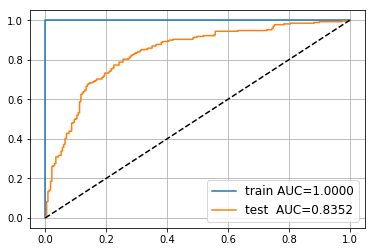

In [19]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [22]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(5722, 2))
# model.add_module('a1', nn.ReLU())
# model.add_module('l2', nn.Linear(8, 2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [23]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [33]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [25]:
X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32)
X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

Let's test that everything is fine

In [26]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [27]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [24]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)### YOUR CODE

        # compute loss, just like before
        ### YOUR CODE
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        ### YOUR CODE
        loss.backward()
        
        # Adam step
        ### YOUR CODE
        opt.step()
        
        # clear gradients
        ### YOUR CODE
        opt.zero_grad()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

In [31]:
lr_scheduler = ReduceLROnPlateau(opt, patience=5)

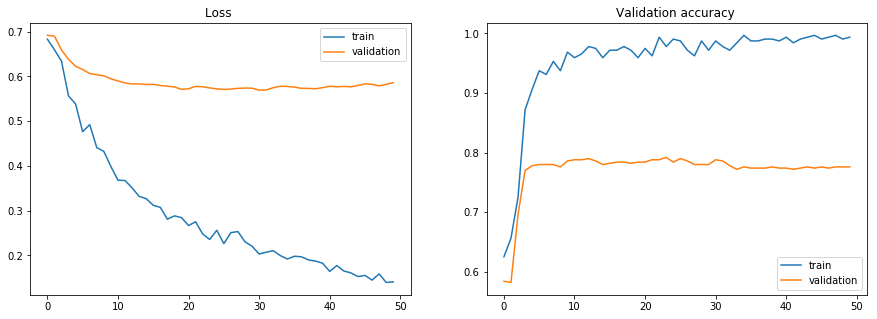

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
)

In [34]:
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

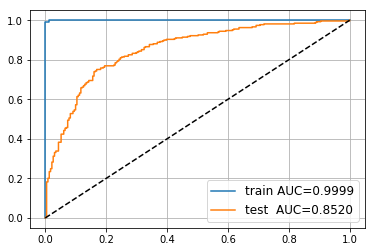

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [36]:
# Your beautiful code here
res_acc = []
res_auc = []
res_acc_tr = []
res_auc_tr = []
k_grid = [500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 5500, 5722]

for k in k_grid:
    bow_vocabulary = []
    for i in ((sorted(bv.items(), key=lambda x: x[1], reverse=True)))[:k]:
        bow_vocabulary.append(i[0])
    word_to_id = dict(zip(bow_vocabulary, np.arange(len(bow_vocabulary))))
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

    model = nn.Sequential()
    model.add_module('l1', nn.Linear(k, 2))

    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
    lr_scheduler = ReduceLROnPlateau(opt, patience=5)

    X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32)
    X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32)

    train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, 
                y_test_torch, show_plots=False)
    
    res_auc.append(roc_auc_score(y_test, model(X_test_bow_torch).detach().cpu().numpy()[:, 1]))
    res_acc.append(accuracy_score(y_test, model(X_test_bow_torch).detach().cpu().numpy().argmax(axis=1)))
    res_auc_tr.append(roc_auc_score(y_train, model(X_train_bow_torch).detach().cpu().numpy()[:, 1]))
    res_acc_tr.append(accuracy_score(y_train, model(X_train_bow_torch).detach().cpu().numpy().argmax(axis=1)))
    display.clear_output(wait=True)

resetting  l1


In [37]:
def plotts(res_acc, res_acc_tr, label = 'Accuracy', plot_train=False):
    plt.plot(k_grid, res_acc, 'o-', label='test')
    if plot_train:
        plt.plot(k_grid, res_acc_tr, 'o-', label = 'train')
    plt.plot(k_grid[np.argmax(res_acc)], np.max(res_acc), 'r*')
    print(f'Optimal number of token is {k_grid[np.argmax(res_acc)]}')
    plt.grid()
    plt.title(f"{label} score")
    plt.xlabel('Number of tokens')
    plt.legend()

Optimal number of token is 2000


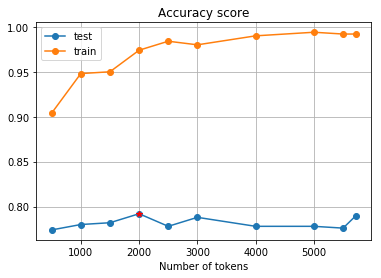

In [38]:
plotts(res_acc, res_acc_tr, label = 'Accuracy', plot_train=True)

Optimal number of token is 2000


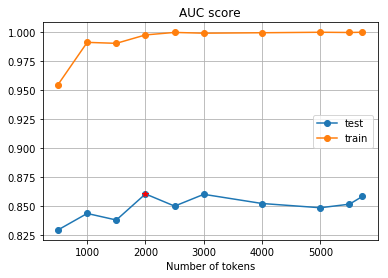

In [39]:
plotts(res_auc, res_auc_tr, label = 'AUC', plot_train = True)

Оптимально брать 2000 наиболее частотных токенов, тогда модель демонстрирует максимальную accuracy и наилучшую точность по ROC-AUC на тестовой выборке

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [41]:
k = 2000
bow_vocabulary = []
for i in ((sorted(bv.items(), key=lambda x: x[1], reverse=True)))[:k]:
    bow_vocabulary.append(i[0])
word_to_id = dict(zip(bow_vocabulary, np.arange(len(bow_vocabulary))))

In [42]:
# Your beautiful code here
def get_tf(word, text):
    cnt = 0
    for w in text.split():
        if w == word:
            cnt +=1
    return cnt/len(text.split())

def get_idf(word, texts): 
    alpha = 1
    n = 0
    for text in texts:
        if word in text.split():
            n+=1
    return np.log(len(text)/(n+alpha))

def all_idfs(features, text):
    idf = []
    for f in features:
        idf.append(get_idf(f, texts_train))
    return idf

def get_values(texts, features): #returns tf-idf matrix
    idf = all_idfs(features, texts)
    arr = np.zeros((len(texts), len(features)))
    j = 0
    for text in texts:
        a = np.zeros(len(features))
        i = 0
        for f in features:
            a[i] = get_tf(f, text) * idf[j]
            i += 1
        arr[j] = a
        j += 1 
    return arr

In [43]:
features = list(word_to_id.keys())

In [44]:
%%time
X_train_tfidf = get_values(texts_train, features)
X_test_tfidf = get_values(texts_test, features)

Wall time: 1min 6s


In [45]:
X_train_tfidf.shape

(500, 2000)

In [46]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

In [83]:
model = nn.Sequential()
# model.add_module('l1', nn.Linear(k, 2))
model.add_module('l1', nn.Linear(2000, 8))
model.add_module('a1', nn.ReLU())
model.add_module('l2', nn.Linear(8, 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, patience=3)

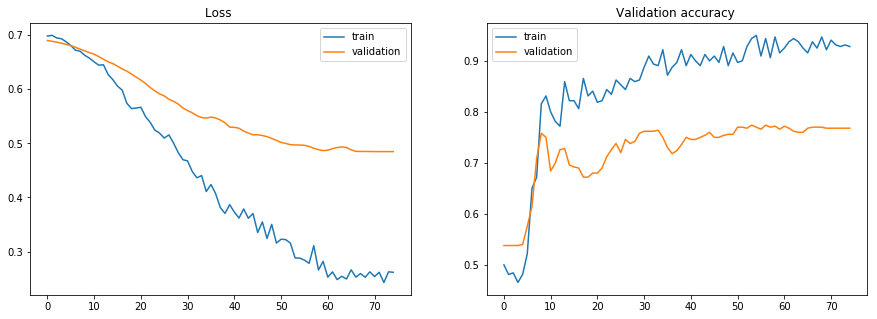

Sequential(
  (l1): Linear(in_features=2000, out_features=8, bias=True)
  (a1): ReLU()
  (l2): Linear(in_features=8, out_features=2, bias=True)
)

In [84]:
train_model(model, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch,
           n_iterations=750, batch_size=32)

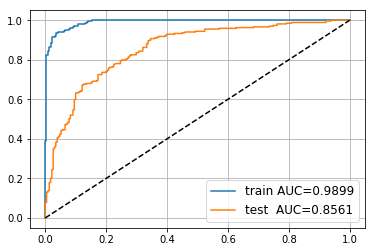

In [85]:
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train, model),
    ('test ', X_test_tfidf_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [86]:
accuracy_score(y_test, model(X_test_tfidf_torch).detach().cpu().numpy().argmax(axis=1))

0.768

## Logistic regr

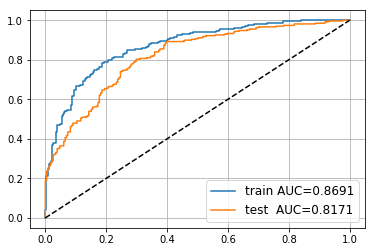

In [138]:
tf_idf_model = LogisticRegression().fit(X_train_tfidf, y_train)

for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tf_idf_model),
    ('test ', X_test_tfidf, y_test, tf_idf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

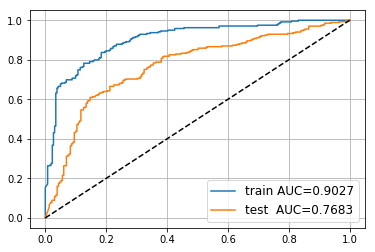

In [139]:
from sklearn.naive_bayes import GaussianNB
model_GNB = GaussianNB(priors=None, var_smoothing=0.0007)
model_GNB.fit(X_train_bow, y_train)

for name, X, y, model in [
    ('train', X_train_bow, y_train, model_GNB),
    ('test ', X_test_bow, y_test, model_GNB)
]:
    proba = model_GNB.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)  
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

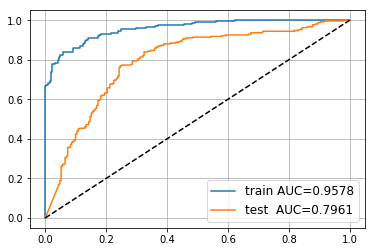

In [140]:
grid = np.linspace(1e-3, 1e-1, 20)
model_GNB = GaussianNB(priors=None, var_smoothing=0.027)
model_GNB.fit(X_train_tfidf, y_train)

for name, X, y, model in [
    ('train', X_train_tfidf, y_train, model_GNB),
    ('test ', X_test_tfidf, y_test, model_GNB)
]:
    proba = model_GNB.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

The results are not very good.
Logistic regression demonstrates better perfomance

*** Best perfomance demonstrates Pytorch neural network model with tf-idf matrix***

*** Changing learning rate helps to increase roc auc to 0.8561 ***

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [16]:
texts = [preprocess(x) for x in texts]

In [18]:
from gensim.models import Word2Vec
model = Word2Vec(texts_train, 
                 size=500,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

C:\Users\vaski\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [17]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros
    
    vector = np.zeros([model.vector_size], dtype='float32')
    phrase_tokenized = tokenizer.tokenize(phrase.lower())# YOUR CODE HERE
    phrase_vectors = [model[x] for x in phrase_tokenized if x in model.vocab.keys()]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)
    return vector

In [37]:
X_w2v_train = np.vstack([get_phrase_embedding(l) for l in texts_train])

In [38]:
X_w2v_test = np.vstack([get_phrase_embedding(l) for l in texts_test])

In [39]:
X_train_w2v_torch = torch.tensor(X_w2v_train, dtype=torch.float32)
X_test_w2v_torch = torch.tensor(X_w2v_test, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [64]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(500, 8))
model.add_module('a1', nn.ReLU())
model.add_module('l2', nn.Linear(8, 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=5e-4)
lr_scheduler = ReduceLROnPlateau(opt, patience=3)

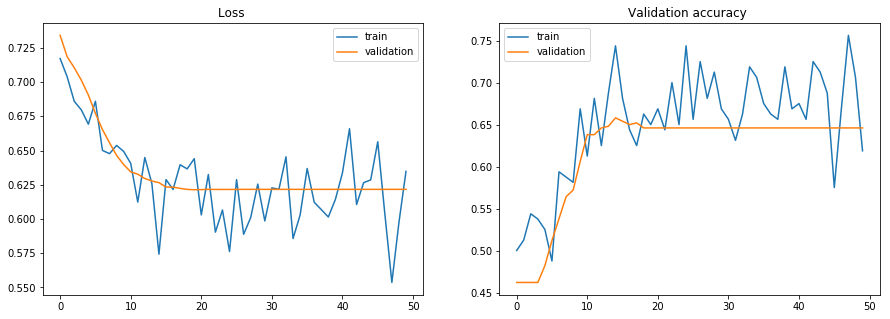

Sequential(
  (l1): Linear(in_features=500, out_features=8, bias=True)
  (a1): ReLU()
  (l2): Linear(in_features=8, out_features=2, bias=True)
)

In [65]:
train_model(model, opt, lr_scheduler, X_train_w2v_torch, y_train_torch, X_test_w2v_torch, y_test_torch,
           n_iterations=500, batch_size=16)

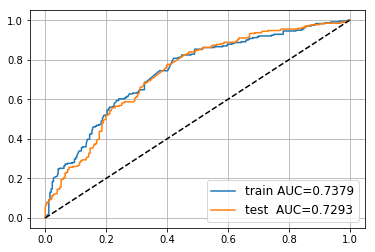

In [66]:
for name, X, y, model in [
    ('train', X_train_w2v_torch, y_train, model),
    ('test ', X_test_w2v_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

***Logistic Regression and parameters***

In [22]:
print('Embedding size')
for i in [150,250,500,750,1000,2000,5000]:
    model = Word2Vec(texts_train, 
                     size=i,      # embedding vector size
                     min_count=5,  # consider words that occured at least 5 times
                     window=5).wv  # define context as a 5-word window around the target word
    X_w2v_train = np.vstack([get_phrase_embedding(l) for l in texts_train])
    X_w2v_test = np.vstack([get_phrase_embedding(l) for l in texts_test])
    w2v_model = LogisticRegression().fit(X_w2v_train, y_train)
    auc = roc_auc_score(y_test, w2v_model.predict_proba(X_w2v_test)[:,1])
    print(i, '\t', auc)

Embedding size
150 	 0.7201837815220714
250 	 0.7200872238046959
500 	 0.7166272389320717
750 	 0.7207389883969808
1000 	 0.7153076167946056
2000 	 0.7225172596919809
5000 	 0.71525129145947


In [23]:
print('Window')
for i in np.arange(1,10):
    model = Word2Vec(texts_train, 
                     size=2000,      # embedding vector size
                     min_count=5,  # consider words that occured at least 5 times
                     window=i).wv  # define context as a 5-word window around the target word
    X_w2v_train = np.vstack([get_phrase_embedding(l) for l in texts_train])
    X_w2v_test = np.vstack([get_phrase_embedding(l) for l in texts_test])
    w2v_model = LogisticRegression().fit(X_w2v_train, y_train)
    auc = roc_auc_score(y_test, w2v_model.predict_proba(X_w2v_test)[:,1])
    print(i, '\t', auc)

Window
1 	 0.7236839987769355
2 	 0.7151708266949903
3 	 0.7171261204718453
4 	 0.7080255556091988
5 	 0.720232060380759
6 	 0.713014371006936
7 	 0.7167157501729993
8 	 0.7107613576015063
9 	 0.7117752136339496


In [25]:
print('Window')
for i in np.arange(1,100,5):
    model = Word2Vec(texts_train, 
                     size=2000,      # embedding vector size
                     min_count=i,  # consider words that occured at least 5 times
                     window=1).wv  # define context as a 5-word window around the target word
    X_w2v_train = np.vstack([get_phrase_embedding(l) for l in texts_train])
    X_w2v_test = np.vstack([get_phrase_embedding(l) for l in texts_test])
    w2v_model = LogisticRegression().fit(X_w2v_train, y_train)
    auc = roc_auc_score(y_test, w2v_model.predict_proba(X_w2v_test)[:,1])
    print(i, '\t', auc)

Window
1 	 0.7231851172371618
6 	 0.7272083554611435
11 	 0.7245208323275237
16 	 0.7239575789761663
21 	 0.7199182477992887
26 	 0.7184698820386551
31 	 0.7182848130803521
36 	 0.7166433318849675
41 	 0.7170537021838137
46 	 0.7226299103622522
51 	 0.7177456991583386
56 	 0.714108691803859
61 	 0.716104217962954
66 	 0.720095270281144
71 	 0.722468980833293
76 	 0.7212298234603067
81 	 0.7147363169668003
86 	 0.7160639855807143
91 	 0.708822156777547
96 	 0.7146960845845605


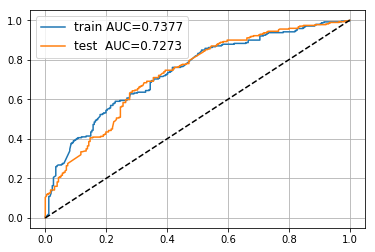

In [27]:
model = Word2Vec(texts_train, 
                     size=2000,      # embedding vector size
                     min_count=6,  # consider words that occured at least 5 times
                     window=1).wv  # define context as a 5-word window around the target word
X_w2v_train = np.vstack([get_phrase_embedding(l) for l in texts_train])
X_w2v_test = np.vstack([get_phrase_embedding(l) for l in texts_test])

w2v_model = LogisticRegression().fit(X_w2v_train, y_train)

for name, X, y, model in [
    ('train', X_w2v_train, y_train, w2v_model),
    ('test ', X_w2v_test, y_test, w2v_model)
]:
    proba = w2v_model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Без дообучения получаем не очень хорошее качество